# Metropolis cipher cracking

This is a student project implementing a Markov chain attack on a simple substitution cipher (i.e. one for which the key is some permutation of the alphabet).

It was inspired by the lecture notes Probability and Computing by Ryan O'Donnell (Fall 2009 version, page 147 in the pdf), link here:

https://www.cs.cmu.edu/~odonnell/papers/probability-and-computing-lecture-notes.pdf


Let's begin by creating a simple cipher to encode a short message.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import gc

plaintext = """Come live with me and be my love,
And we will all the pleasures prove,
That Valleys, groves, hills, and fields,
Woods, or steepy mountain yields.

And we will sit upon the Rocks,
Seeing the Shepherds feed their flocks,
By shallow Rivers to whose falls
Melodious birds sing Madrigals.

And I will make thee beds of Roses
And a thousand fragrant posies,
A cap of flowers, and a kirtle
Embroidered all with leaves of Myrtle;

A gown made of the finest wool
Which from our pretty Lambs we pull;
Fair lined slippers for the cold,
With buckles of the purest gold;"""

#part of Marlowe's  'The Passionate Shepherd to His Love'; later re-written in lowercase and without punctuation for simplicity
def strip(string):
    return string.lower().replace(",","").replace(".","").replace(";","").replace("\n"," ").replace("  ", " ")
plaintext = strip(plaintext)

def encrypt(message, key): #encode/decode, function takes str and dict inputs
    new_message = ""
    for c in message:
        try:
            key[c]
        except:
            new_message += c
        else:
            new_message += key[c]
    return new_message

def decrypt(message, key):
    inverse_key = {}
    for c in alphabet:
        inverse_key[key[c]] = c
    return encrypt(message, inverse_key)

alphabet = "abcdefghijklmnopqrstuvwxyz " #contains the space ' ' as well
def random_key():
    key = {}
    for letter in alphabet: #init as   id: A-> A
        key[letter] = letter
    for tau in range(1000): #apply random transpositions
        i = alphabet[random.randint(0,len(alphabet)-1)]
        j = alphabet[random.randint(0,len(alphabet)-1)]
        #do allow for i==j, so that the final permutation isn't necessarily even
        temp = key[i]
        key[i] = key[j]
        key[j] = temp
    #next t
    return key

secret_key = random_key()
print(secret_key, "\n")

ciphertext = encrypt(plaintext, secret_key)
print(ciphertext)

{'a': 'n', 'b': 'm', 'c': 'g', 'd': 'w', 'e': 's', 'f': 'j', 'g': 'r', 'h': 'l', 'i': 't', 'j': 'f', 'k': 'q', 'l': 'u', 'm': 'h', 'n': 'a', 'o': 'e', 'p': 'c', 'q': 'd', 'r': 'p', 's': 'z', 't': 'y', 'u': 'i', 'v': 'x', 'w': 'o', 'x': 'k', 'y': 'v', 'z': ' ', ' ': 'b'} 

gehsbutxsbotylbhsbnawbmsbhvbuexsbnawbosbotuubnuubylsbcusnzipszbcpexsbylnybxnuusvzbrpexszbltuuzbnawbjtsuwzboeewzbepbzysscvbheiayntabvtsuwzbnawbosbotuubztybiceabylsbpegqzbzsstarbylsbzlsclspwzbjsswbylstpbjuegqzbmvbzlnuueobptxspzbyebolezsbjnuuzbhsuewteizbmtpwzbztarbhnwptrnuzbnawbtbotuubhnqsbylssbmswzbejbpezszbnawbnbyleiznawbjpnrpnaybceztszbnbgncbejbjueospzbnawbnbqtpyusbshmpetwspswbnuubotylbusnxszbejbhvpyusbnbreoabhnwsbejbylsbjtaszyboeeuboltglbjpehbeipbcpsyyvbunhmzbosbciuubjntpbutaswbzutccspzbjepbylsbgeuwbotylbmigquszbejbylsbcipszybreuw


Notice that once we treat the space character on equal footing with the letters, word lengths change dramatically. 

Now we proceed to cracking the cipher, assuming only that the message was encrypted with some 1:1 simple substitution cipher. The method will base on frequency analysis, and we first need to know some general statistics about letter frequencies in English. To allow for code flexibility, all data is extracted from books by the cell below. I choose Moby Dick (here, stored in Moby_Dick.txt) as the sole reference but other books could be added, too. The text I use was downloaded from Project Gutenberg.

In [2]:
letter_frequencies = {}
for letter in alphabet:
    letter_frequencies[letter] = 0

pairs = [l1+l2 for l1 in alphabet for l2 in alphabet]
pair_frequencies = {}
for pair in pairs:
    pair_frequencies[pair] = 0

word_frequencies = {}

letter_count = 0
word_count = 0

book_titles = ["Moby_Dick"]
for title in book_titles:
    book = open(title+".txt")
    book_str = book.read().lower()
    current_word = ""
    last_char = " " #a space
    for character in book_str:
        if character == "\n":
            character = " ";
        try:
            letter_frequencies[character] += 1
        except:
            pass #ignore non-letter characters
        else: #if a letter
            letter_count += 1
            if character == " ":
                word_count += 1;
                try:
                    word_frequencies[current_word] += 1
                except:
                    word_frequencies[current_word] = 1
                current_word = ""
            else:
                current_word += character
            #endif
            pair_frequencies[last_char+character] += 1
            last_char = character
        #endif
    #next character
    book.close()
    del book_str
    gc.collect() #free the allocated memory

for word in word_frequencies.keys():
    word_frequencies[word] /= word_count

for letter in alphabet:
    letter_frequencies[letter] /= letter_count

for pair in pairs:
    pair_frequencies[pair] /= letter_count

len(word_frequencies.keys())

19958

The average adult knows 20000-35000 words, so we should be OK having analysed one book. The word dictionary will only be needed to verify if a potential key decodes the ciphertext into something sensible, so there is little need to account for seldomly used words.

<BarContainer object of 27 artists>

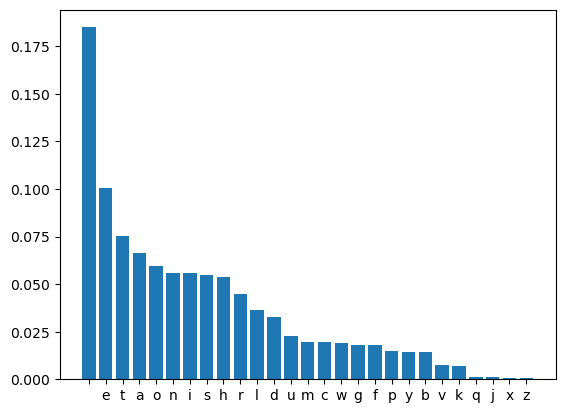

In [3]:
S = sorted(letter_frequencies.items(), key=lambda x: x[1], reverse = True)
plt.bar([s[0] for s in S],[s[1] for s in S])

We can now perform a similar analysis on the ciphertext...

<BarContainer object of 27 artists>

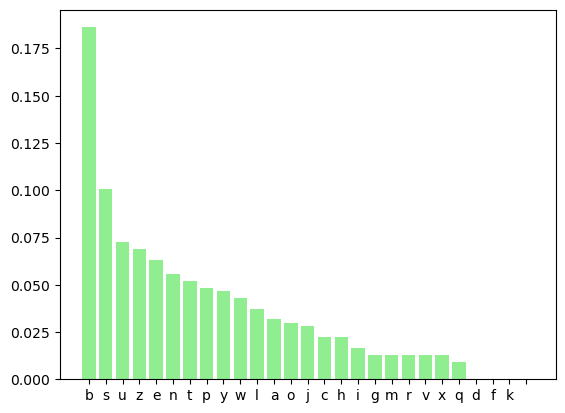

In [4]:
ciphertext_frequencies = {}
for character in alphabet:
    ciphertext_frequencies[character] = 0

cipher_pair_f = {}
for pair in pairs:
    cipher_pair_f[pair] = 0

last_char = " " #a space
for character in ciphertext:
    if character == "\n":
        character = " ";
    ciphertext_frequencies[character] += 1
    cipher_pair_f[last_char+character] += 1
    last_char = character

for character in alphabet:
    ciphertext_frequencies[character] /= len(ciphertext)

for pair in pairs:
    cipher_pair_f[pair] /= len(ciphertext)

S_cipher = sorted(ciphertext_frequencies.items(), key=lambda x: x[1], reverse = True)
plt.bar([s[0] for s in S_cipher],[s[1] for s in S_cipher], color = "lightgreen")

... and try to match the letters in accordance with their popularity in order to guess the 

In [5]:
most_probable_key = {} #the word key will always describe a transormation: plaintext->ciphertext
for i in range(len(alphabet)):
    most_probable_key[S[i][0]] = S_cipher[i][0]
print(most_probable_key, "\n")
print(decrypt(ciphertext, most_probable_key))

{' ': 'b', 'e': 's', 't': 'u', 'a': 'z', 'o': 'e', 'n': 'n', 'i': 't', 's': 'p', 'h': 'y', 'r': 'w', 'l': 'l', 'd': 'a', 'u': 'o', 'm': 'j', 'c': 'c', 'w': 'h', 'g': 'i', 'f': 'g', 'p': 'm', 'y': 'r', 'b': 'v', 'v': 'x', 'k': 'q', 'q': 'd', 'j': 'f', 'x': 'k', 'z': ' '} 

fowe tive uihl we ndr pe wb tove ndr ue uitt ntt hle ctenagsea csove hlnh vntteba ysovea litta ndr mietra uoora os aheecb wogdhnid bietra ndr ue uitt aih gcod hle sofka aeeidy hle aleclesra meer hleis mtofka pb alnttou sivesa ho uloae mntta wetorioga pisra aidy wnrsiynta ndr i uitt wnke hlee pera om soaea ndr n hlogandr msnysndh coaiea n fnc om mtouesa ndr n kishte ewpsoireser ntt uihl tenvea om wbshte n youd wnre om hle mideah uoot ulifl msow ogs csehhb tnwpa ue cgtt mnis tider aticcesa mos hle fotr uihl pgfktea om hle cgseah yotr


As we can see, the naive approach does not work, which was quite easy to predict - the character frequencies in a portion of text are only hoped to settle on their standard values for very long texts. Our message is far too short to tell the difference between two letters of comparable frequencies.

In [6]:
len(ciphertext)

537

We will adopt a different approach where we use the Metropolis algorithm to generate possible keys such that the probability of selecting a key is proportional to how well the decyphered text reflects standard frequency statistics. We will analyse probabilities of occurences of pairs of letters rather than of single characters, which is a more accurate model. It is worth to note that the approximation does not reflect all statistical properties of character sequences. In fact, any pair frequency table could be reproduced by a Markovian model in which the next letter depends only on the current one and not on the ones preceeding it, a property which obviously is not true for the natural language ("ll" is possible, but "lll" is not). The approximation will turn out to be sufficient for our purposes. Also note that treating the space character as a letter allows us to easily include common word beginnings and endings in the pair frequency table.

We will need a qualitative measure of how good a potential key is. We choose to compute the Pearson correlation coefficient between frequency vector for pairs of characters in the decyphered message and the standard vector for English. Spearman's rank correlation does not seem suitable for this kind of task, since, among the 27*27 possible pairs, most are relatively rare, and swapping two rare letters should have much less effect than exchanging two popular ones.

Note that the r score computation could be optimized, since the means and standard deviations do not change between different calls of the function. Also, when we attempt a step in the random walk, we only need to consider the difference in r caused by swapping two letters, a fact we could use to greatly reduce the amount of computation. However, there will be no such need here.

In [7]:
std_f_vector = np.array([pair_frequencies[pair] for pair in pairs])
def r(key):
    freq = [] #create frequency vector
    for pair in pairs:
        freq.append(cipher_pair_f[ key[pair[0]]+key[pair[1]] ] )
    return np.corrcoef( np.array(freq), std_f_vector)[0][1] #Pearson correlation

r(most_probable_key)

0.5054912436069318

Let's see some typical values of r.

MIN -0.1224437721492662 MAX 0.36353562885988455


(array([ 84., 318., 308., 159.,  75.,  34.,  10.,   7.,   3.,   2.]),
 array([-0.12244377, -0.07384583, -0.02524789,  0.02335005,  0.07194799,
         0.12054593,  0.16914387,  0.21774181,  0.26633975,  0.31493769,
         0.36353563]),
 <BarContainer object of 10 artists>)

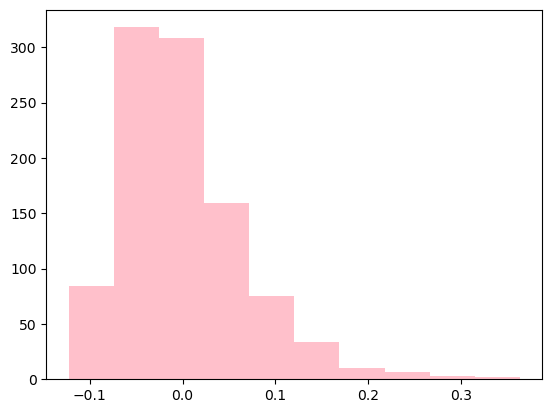

In [8]:
r_scores = np.array( [r(random_key()) for i in range(1000)] )
print("MIN", np.min(r_scores), "MAX", np.max(r_scores))
plt.hist(r_scores, color = "pink")

We will choose the desired stationary distribution probability to be proportional to
$$
z = e^{\beta r},
$$
where $\beta>0$ is some fixed parameter which acts similarly to (inverse) temperature - the lower the value of $\beta$, the more likely the system is to sit off the maximum of $r$. This choice of $z$ has the following advantages.
- $z$ is necessarily positive.
- We can tune $\beta$ to fit our needs - decoding a large volume of text would probably work best with a high $\beta$, since the actual solution is likely not too far from the maximum of $r$.
- The stationary distribution is invariant under the constant shift $r \to r+r'$, which is why we can focus on differences in $r$ scores, and not their actual values. This property possibly makes it easier to choose a suitable $r$.

NB With very high $\beta$, the ratios between $z$ values will either be very large or very small, which would mean that the transition probabilities in the standard Metropolis algorithm would be very close to 0 or 1, and so it would take very long to reach the stationary distribution. The problem could possibly be evaded by using different transition probabilities for the random walk.

In [9]:
def validity_score(key): #how valid of a message does a key produce
    decrypted = decrypt(ciphertext, key)
    total_freq = 0
    valid_freq = 0
    current_word = ""
    for character in decrypted:
        if character == " " or character == "\n":
            try:
                word_frequencies[current_word]
            except:
                total_freq += word_frequencies["i"] #penalty for getting a word wrong, estimated by the freq of a very common word ("I")
            else:
                valid_freq += word_frequencies[current_word]
                total_freq += word_frequencies[current_word]
            current_word = ""
                
        else:
            current_word += character
    return valid_freq/total_freq

print(decrypt(ciphertext, most_probable_key))
validity_score(most_probable_key)

fowe tive uihl we ndr pe wb tove ndr ue uitt ntt hle ctenagsea csove hlnh vntteba ysovea litta ndr mietra uoora os aheecb wogdhnid bietra ndr ue uitt aih gcod hle sofka aeeidy hle aleclesra meer hleis mtofka pb alnttou sivesa ho uloae mntta wetorioga pisra aidy wnrsiynta ndr i uitt wnke hlee pera om soaea ndr n hlogandr msnysndh coaiea n fnc om mtouesa ndr n kishte ewpsoireser ntt uihl tenvea om wbshte n youd wnre om hle mideah uoot ulifl msow ogs csehhb tnwpa ue cgtt mnis tider aticcesa mos hle fotr uihl pgfktea om hle cgseah yotr


0.013324501849092023

The validity score is very low, as the message makes no sense. The score for the actual solution would be 0.92 - there are some words Marlowe uses that don't occur in Moby Dick. This shouldn't be much of a problem, though, as the method only serves to filter out plausible solutions, which then have to be verified by eye.

Here, we only choose to stop the search after exceeding validity>0.9 for convenience. In practice, one would have no prior knowledge of the desired validity score and would have to make the program print possible solutions until finding the correct one or understanding the meaning of the message. (We could never realistically count on validity being 1, since the message could contain some rare name of a person or a geographical location, or words from a foreign language for example.)

In [10]:
beta = 1000 #fitted by trial and error

def transpose(key, l1, l2):
    new_key = {}
    for l in alphabet:
        new_key[l] = key[l]
    new_key[l1] = key[l2]
    new_key[l2] = key[l1]
    return new_key

def Metropolis_random_walk(key, steps = 100):
    current_r = r(key)
    for step in range(steps):
        l1 = alphabet[random.randint(0,len(alphabet)-1)]
        l2 = alphabet[random.randint(0,len(alphabet)-1)]
        #do allow for l1 == l2 to avoid complications arising from periodicity
        new_key = transpose(key, l1, l2)
        new_r = r(new_key)
        A = np.exp( beta*(new_r-current_r) )
        if random.random() < A: #make a step
            key = new_key
            current_r = new_r
    return key
        
def attempt_cracking(starting_key):
    key = transpose(starting_key, "a", "a") #copy
    validity = validity_score(key)
    sensible_keys = []
    count = 0
    while validity < 0.9 and count < 10000:
        count += 1
        key = Metropolis_random_walk(key, steps = 27*27+random.randint(0,10))
        validity = validity_score(key)
        if validity>0.7:
            sensible_keys.append(key)
    print("finished after ", count, "walks")
    return sensible_keys

sensible_keys = attempt_cracking(most_probable_key)      
        

finished after  12 walks


In [11]:
len(sensible_keys)

10

In [12]:
for key in sensible_keys:
    print(decrypt(ciphertext,key), "\n")

pome live with me and ce my love and we will all the bleasures brove that valleys groves hills and fields woods or steeby mountain yields and we will sit ubon the ropqs seeing the shebherds feed their flopqs cy shallow rivers to whose falls melodious cirds sing madrigals and i will maqe thee ceds of roses and a thousand fragrant bosies a pab of flowers and a qirtle emcroidered all with leaves of myrtle a gown made of the finest wool whiph from our bretty lamcs we bull fair lined slibbers for the pold with cupqles of the burest gold 

poce lime with ce and ve cy lome and we will all the bleasures brome that malleys gromes hills and fields woods or steeby countain yields and we will sit ubon the ropks seeing the shebherds feed their flopks vy shallow rimers to whose falls celodious virds sing cadrigals and i will cake thee veds of roses and a thousand fragrant bosies a pab of flowers and a kirtle ecvroidered all with leames of cyrtle a gown cade of the finest wool whiph froc our bretty l

Depending on the seed, the final plausible solution shown by the above program could still be imperfect. However, the model produces a fairly readable message, and minor errors can easily be spotted and correcter by the reader.